In [171]:
import os

import cv2
import matplotlib.pyplot as plt
import math

In [172]:
root = "../dataset/roadpoles_v1"

# Image Path
test_image = "../dataset/roadpoles_v1/train/images/frame_000010.PNG"
test_label = "../dataset/roadpoles_v1/train/labels/frame_000010.txt"

dataset_splits = ["train", "valid"]

In [173]:
def get_poles(pole_files):
    poles = []

    with open(pole_files, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls, x_center, y_center, w_norm, h_norm = map(float, parts)
                poles.append((x_center, y_center, w_norm, h_norm))
    return poles

In [174]:
def get_pole_stats(dataset_split):
    img_dir = os.path.join(root, dataset_split, "images")
    lab_dir = os.path.join(root, dataset_split, "labels")

    img_files = [f for f in os.listdir(img_dir)]
    pole_files = [f for f in os.listdir(lab_dir)]

    tot_img_file = len(img_files)
    tot_pole_file = len(pole_files)
    tot_poles = 0
    sum_x, sum_y = 0.0, 0.0

    for pole in pole_files:
        path = os.path.join(lab_dir, pole)
        poles = get_poles(path)
        tot_poles += len(poles)

        for x, y,_,_ in poles:
            sum_x += x
            sum_y += y

    avg_poles = tot_poles / tot_pole_file
    avg_x = sum_x / tot_poles
    avg_y = sum_y / tot_poles

    return tot_img_file, tot_pole_file, tot_poles, avg_poles, avg_x, avg_y

In [175]:
def get_pole_min_max_pixel(dataset_split, width=1920, height=1208):
    lab_dir = os.path.join(root, dataset_split, "labels")
    pole_files = [f for f in os.listdir(lab_dir)]

    min_x = math.inf
    max_x = -math.inf
    min_y = math.inf
    max_y = -math.inf

    for pole in pole_files:
        path = os.path.join(lab_dir, pole)
        poles = get_poles(path)
        for x_norm, y_norm, w_norm, h_norm in poles:
            x_pix = x_norm * width
            y_pix = y_norm * height
            w_pix = w_norm * width
            h_pix = h_norm * height
            x1 = x_pix - w_pix / 2
            x2 = x_pix + w_pix / 2
            y1 = y_pix - h_pix / 2
            y2 = y_pix + h_pix / 2
            min_x = min(min_x, x1)
            max_x = max(max_x, x2)
            min_y = min(min_y, y1)
            max_y = max(max_y, y2)

    return int(min_x), int(max_x), int(min_y), int(max_y)

In [176]:
train, valid, test = 0, 0, 0
test_path = os.path.join(root, "test", "images")

test = len([f for f in os.listdir(test_path)])

print("---------- Data Statistics ----------")
for split in dataset_splits:

    tot_img_file, tot_pole_file, tot_poles, avg_poles, avg_x, avg_y = get_pole_stats(split)
    print("same amount of image as labels ?: " + str(tot_img_file == tot_pole_file))
    if split == "train":
        train = tot_img_file
    else:
        valid = tot_img_file
    print("avg pole per image: " + str(round(avg_poles, 2)))
    print("avg pole position: (" + str(round(avg_x, 2)) + ", " + str(round(avg_y, 2)) + ")")
    print("")

total_images = train + valid + test


print("Amount of train images: " + str(train))
print("Amount of valid images: " + str(valid))
print("Amount of test images: " + str(test))

print("train, test, validate split: " + str(train/total_images))


---------- Data Statistics ----------
same amount of image as labels ?: True
avg pole per image: 1.22
avg pole position: (0.46, 0.61)

same amount of image as labels ?: True
avg pole per image: 1.23
avg pole position: (0.46, 0.61)

Amount of train images: 322
Amount of valid images: 92
Amount of test images: 46
train, test, validate split: 0.7


In [177]:
print("--------- Crop Analysis ----------")
for split in ["train", "valid"]:
    min_x, max_x, min_y, max_y = get_pole_min_max_pixel(split)
    print(f"{split}")
    print(f"  X: min {min_x}, max {max_x}")
    print(f"  Y: min {min_y}, max {max_y}\n")

--------- Crop Analysis ----------
train
  X: min 0, max 1906
  Y: min 543, max 1139

valid
  X: min 15, max 1913
  Y: min 574, max 1115



In [178]:
def viz_example():
    image = cv2.imread(test_image)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    print("image shape: " + str(image.shape))

    boxes = []
    with open(test_label, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls, x_center, y_center, w_norm, h_norm = map(float, parts)
                x_center_pix = x_center * width
                y_center_pix = y_center * height
                w_pix = w_norm * width
                h_pix = h_norm * height
                boxes.append((x_center_pix, y_center_pix, w_pix, h_pix))

    for x, y, w, h in boxes:
        top_left = (int(x - w/2), int(y - h/2))
        bottom_right = (int(x + w/2), int(y + h/2))
        cv2.rectangle(rgb_image, top_left, bottom_right, (255,0,0), 2)
        cv2.circle(rgb_image, (int(x), int(y)), 3, (0,255,0), -1)  # center

    plt.figure(figsize=(25,15))
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()

image shape: (1208, 1920, 3)


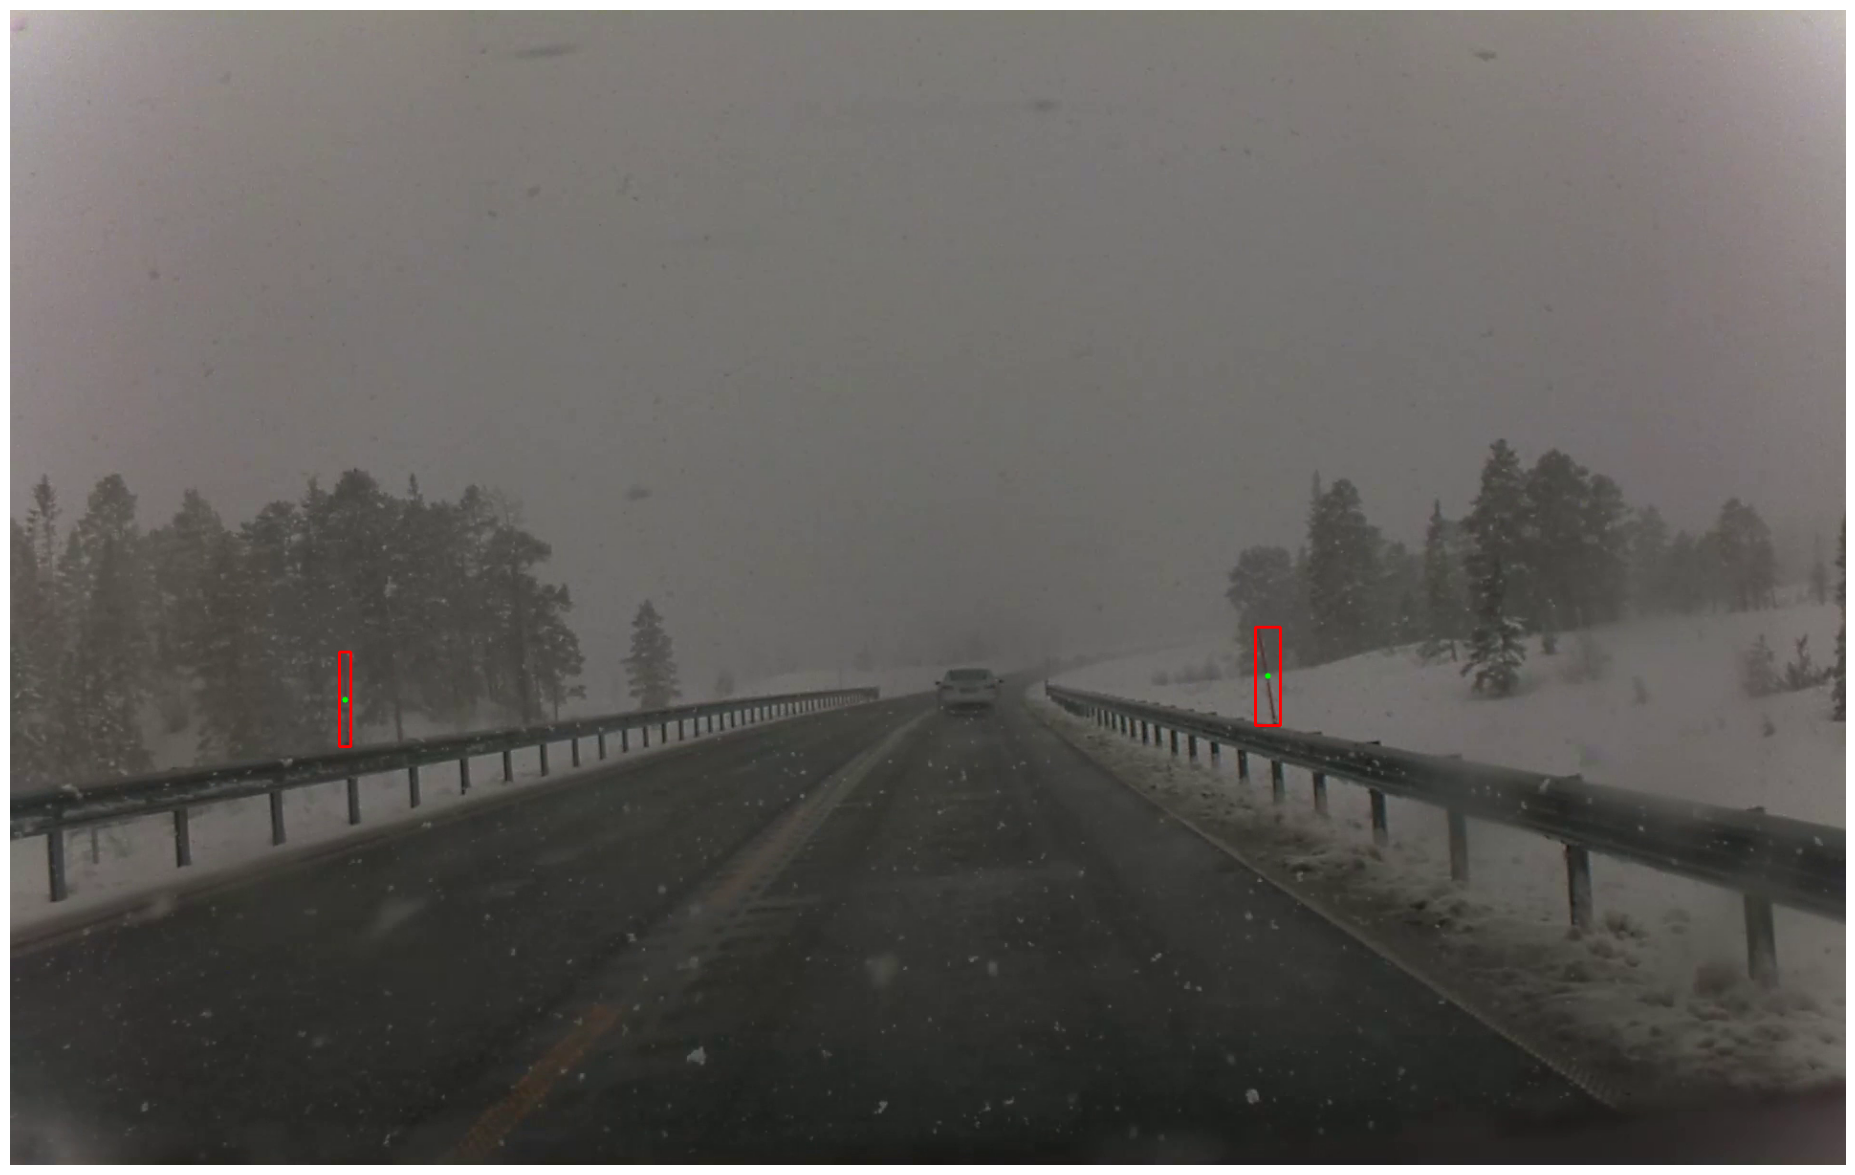

In [179]:
viz_example()